# Load dataset

In [22]:
import uproot
import awkward as ak
import numpy as np
from matplotlib import pyplot as plt
from math import floor

In [2]:
ssww = uproot.open("/eos/user/g/glavizza/nanoAOD/ntuples_polarized/SSWW_polarized_CMrf.root:trees/ssww/SSWW_CMrf_LL/Events")

   ## demo on how to get a pd df for quick analysis
   Note that you need to exclude the branches `CleanJet_pt(eta,phi,mass)` because they're not flat! We'll need awkward for that

In [3]:
flat_variables = [k for k in ssww.keys() if 'CleanJet_' not in k]
print ('Creating FLAT NTUPLE (pd dataframe) with ', ', '.join(flat_variables))
ssww_pd = ssww.arrays(flat_variables, library='pd')

Creating FLAT NTUPLE (pd dataframe) with  XSWeight, nCleanJet, ptj1, ptj2, etaj1, etaj2, phij1, phij2, mj1, mj2, mjj, detajj, ptl1, ptl2, etal1, etal2, phil1, phil2, pdgIdl1, pdgIdl2, mll, ptMET, phiMET, ptv1, ptv2, etav1, etav2, phiv1, phiv2, pdgIdv1, pdgIdv2, weight


In [4]:
ssww_pd

,XSWeight,nCleanJet,ptj1,ptj2,etaj1,etaj2,phij1,phij2,mj1,mj2,...,phiMET,ptv1,ptv2,etav1,etav2,phiv1,phiv2,pdgIdv1,pdgIdv2,weight
0,0.000001,3,93.035866,92.568840,-2.399902,2.033691,1.329590,1.329590,8.699919,11.414845,...,1.243566,45.0000,33.000000,-0.379883,-0.876953,1.789062,1.039062,14.0,14.0,0.000065
1,0.000001,2,131.850616,63.007259,-2.770508,3.125977,-0.577393,-0.577393,15.959492,10.241407,...,0.574508,30.3125,14.312500,0.837891,-3.789062,0.433594,-2.773438,14.0,12.0,0.000065
2,0.000001,3,173.154785,61.253094,1.701172,-3.809570,0.618530,0.618530,26.120375,11.212483,...,3.024451,156.5000,12.687500,-0.017822,1.070312,-3.125000,2.187500,12.0,14.0,0.000065
3,0.000001,7,140.346786,135.559814,3.371094,-1.844971,1.710938,1.710938,21.245579,10.421633,...,-0.125183,70.2500,28.812500,-0.900391,0.904297,0.785156,-0.679688,12.0,12.0,0.000065
4,0.000001,7,117.264397,77.769096,-2.772461,1.155518,-0.849365,-0.849365,14.153778,4.667251,...,-1.708070,116.5000,70.000000,0.587891,-1.453125,-0.718750,2.671875,12.0,16.0,0.000065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153895,0.000001,6,202.521057,124.440140,-1.461182,3.062988,0.085739,0.085739,19.745804,19.841438,...,3.023926,178.0000,29.000000,0.783203,1.960938,2.656250,2.664062,12.0,12.0,0.000065
153896,0.000001,5,153.651657,105.192299,-2.015625,1.405029,-3.095703,-3.095703,10.373075,15.445271,...,-0.816243,49.1250,47.875000,0.474609,2.085938,-1.320312,-2.234375,14.0,14.0,0.000065
153897,0.000001,4,217.794022,113.000122,-2.128906,3.973633,2.668945,2.668945,41.217140,19.985561,...,0.619845,52.0000,32.625000,-1.835938,1.464844,-0.917969,1.281250,12.0,14.0,0.000065
153898,0.000001,5,96.247742,92.818321,1.073242,-3.510254,1.446045,1.446045,12.417070,13.075471,...,-2.563965,79.7500,5.921875,0.947266,2.789062,-2.429688,-1.238281,12.0,12.0,0.000065


# Utils for scaling and manipulation of inputs

In [5]:
PI= 3.1416015625

def logistic(x):
    return 1/(1+np.exp(-x))

def logit(x, clip=1e-6):
    x = np.clip(x, a_min=clip, a_max=1-clip)
    return np.log(x/(1-x))

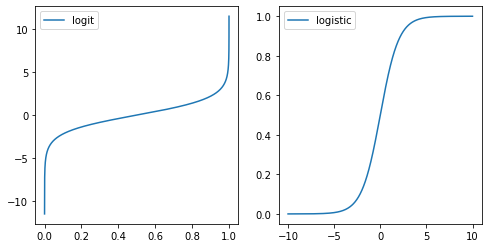

In [6]:
f, axs = plt.subplots(1, 2, figsize=(8,4))
x = np.linspace(1e-5, 1-1e-5, 10000)
axs[0].plot(x, logit(x), label="logit")
axs[0].legend()

x = np.linspace(-10, 10, 10000)
axs[1].plot(x, logistic(x), label="logistic")
axs[1].legend()

# Dataset preparation: create the tensors (we'll do flat first)

### leptons

In [7]:
lepPt1 = ssww['ptl1'].array(library='np')
lepPt2 = ssww['ptl2'].array(library='np')
lepPt1scaled = np.log(1 + lepPt1 - 20.) # 20. is the minimum pt
lepPt2scaled = np.log(1 + lepPt2 - 20.)

lepEta1 = ssww['etal1'].array(library='np')
lepEta2 = ssww['etal2'].array(library='np')

lepPhi1 = ssww['phil1'].array(library='np')
lepPhi2 = ssww['phil2'].array(library='np')
lepPhi1scaled = logit( (lepPhi1 + PI )/(2*PI), clip=1e-6)
lepPhi2scaled = logit( (lepPhi2 + PI )/(2*PI), clip=1e-6)

**Demo of scaling**

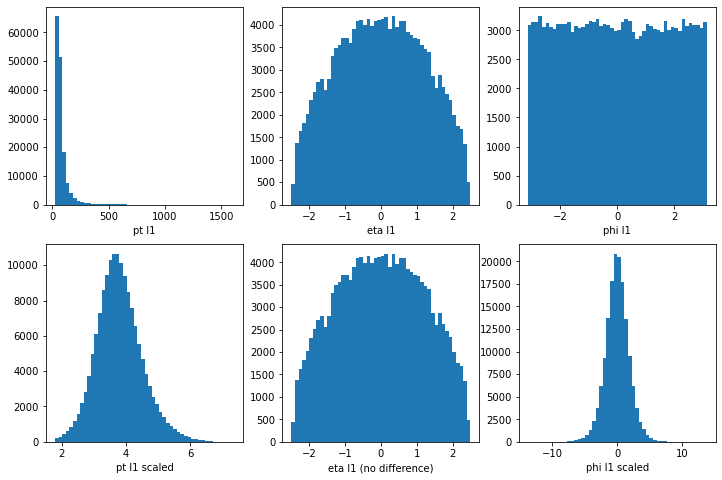

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
ax[0][0].hist(lepPt1, bins=50)
ax[0][0].set_xlabel('pt l1')
ax[1][0].hist(lepPt1scaled, bins=50)
ax[1][0].set_xlabel('pt l1 scaled')

ax[0][1].hist(lepEta1, bins=50)
ax[0][1].set_xlabel('eta l1')
ax[1][1].hist(lepEta1, bins=50)
ax[1][1].set_xlabel('eta l1 (no difference)')

ax[0][2].hist(lepPhi1, bins=50)
ax[0][2].set_xlabel('phi l1')
ax[1][2].hist(lepPhi1scaled, bins=50)
ax[1][2].set_xlabel('phi l1 scaled')

plt.show()

**Now merge into single object**

In [9]:
lepPt = np.stack([lepPt1scaled,lepPt2scaled], axis=1)
lepEta = np.stack([lepEta1,lepEta2], axis=1)
lepPhi = np.stack([lepPhi1scaled,lepPhi2scaled], axis=1)

lepTensor = np.stack([lepPt, lepEta, lepPhi], axis=2)

lep_mean = np.mean(lepTensor, axis=(0,1))
lep_std = np.std(lepTensor, axis=(0,1))
lep_scaling = np.stack([lep_mean, lep_std], axis=1)
print (np.shape(lep_scaling))
lepTensorNorm = (lepTensor - lep_mean) /lep_std

print (np.shape(lepPt), "N events x 2 leptons")
print (np.shape(lepTensor), "N events x 2 leptons x 3 features (pt, eta, phi)")
print (np.shape(lepTensorNorm))

(3, 2)
(153900, 2) N events x 2 leptons
(153900, 2, 3) N events x 2 leptons x 3 features (pt, eta, phi)
(153900, 2, 3)


### met

In [10]:
metPt = np.log(1 + ssww['ptMET'].array(library='np') - 30.) # 30 is met minimum
metPhi = logit( (ssww['phiMET'].array(library='np') + PI )/(2*PI), clip=1e-6)

metTensor = np.stack([np.expand_dims(metPt, 1),np.expand_dims(metPhi, 1)], axis=2)

met_mean = np.mean(metTensor, axis=(0,1))
met_std = np.std(metTensor, axis=(0,1))
met_scaling = np.stack([met_mean, met_std], axis=1)

metTensorNorm = (metTensor - met_mean) /met_std

print (np.shape(metTensor))
print (np.shape(metTensorNorm))

(153900, 1, 2)
(153900, 1, 2)


### VBS jets (no scaling, will not use them)

In [11]:
jetPt1 = ssww['ptj1'].array(library='np')
jetPt2 = ssww['ptj2'].array(library='np')

jetEta1 = ssww['etaj1'].array(library='np')
jetEta2 = ssww['etaj2'].array(library='np')

jetPhi1 = ssww['phij1'].array(library='np')
jetPhi2 = ssww['phij2'].array(library='np')

jetM1 = ssww['mj1'].array(library='np')
jetM2 = ssww['mj2'].array(library='np')

jetPt = np.stack([jetPt1,jetPt2], axis=1)
jetEta = np.stack([jetEta1,jetEta2], axis=1)
jetPhi = np.stack([jetPhi1,jetPhi2], axis=1)
jetM = np.stack([jetM1,jetM2], axis=1)

VBSjetTensor = np.stack([jetPt, jetEta, jetPhi, jetM], axis=2)

print (np.shape(VBSjetTensor))

(153900, 2, 4)


### di-jet variables

In [12]:
mjj = np.log(1 + ssww['mjj'].array(library='np') - 500.) # min is 500 GeV
detajj = ssww['detajj'].array(library='np') #no need to scale

jjTensor = np.stack([np.expand_dims(mjj, 1),np.expand_dims(detajj, 1)], axis=2)

jj_mean = np.mean(jjTensor, axis=(0,1))
jj_std = np.std(jjTensor, axis=(0,1))
jj_scaling = np.stack([jj_mean, jj_std], axis=1)

jjTensorNorm = (jjTensor - jj_mean) /jj_std

print (np.shape(jjTensor))

(153900, 1, 2)


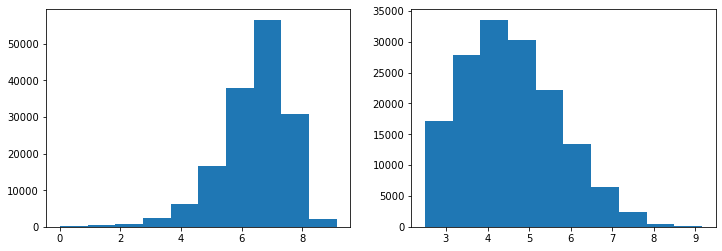

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(mjj)
ax[1].hist(detajj)

plt.show()

### neutrinos

In [14]:
nuPt1 = np.log(1 + ssww['ptv1'].array(library='np'))
nuPt2 = np.log(1 + ssww['ptv2'].array(library='np'))

nuEta1 = ssww['etav1'].array(library='np')
nuEta2 = ssww['etav2'].array(library='np')

nuPhi1 = logit( (ssww['phiv1'].array(library='np') + PI )/(2*PI), clip=1e-6)
nuPhi2 = logit( (ssww['phiv2'].array(library='np') + PI )/(2*PI), clip=1e-6)

nuPt = np.stack([nuPt1,nuPt2], axis=1)
nuEta = np.stack([nuEta1,nuEta2], axis=1)
nuPhi = np.stack([nuPhi1,nuPhi2], axis=1)

nuTensor = np.stack([nuPt, nuEta, nuPhi], axis=2)

nu_mean = np.mean(nuTensor, axis=(0,1))
nu_std = np.std(nuTensor, axis=(0,1))
nu_scaling = np.stack([nu_mean, nu_std], axis=1)

nuTensorNorm = (nuTensor - nu_mean)/nu_std

print (np.shape(nuTensor))
print (np.shape(nuTensorNorm))

(153900, 2, 3)
(153900, 2, 3)


## non VBS jets

Would be interesting to try and **add a label to the VBS jets** (in the events, they're the two jets with the highest mjj). I will not try for the moment!

In [15]:
jet_variables = [k for k in ssww.keys() if 'CleanJet_' in k]
df = ssww.arrays(jet_variables)

#df

In [16]:
Jets = ak.zip({"pt": df.CleanJet_pt, 
            "eta": df.CleanJet_eta, 
            "phi": df.CleanJet_phi, 
            "m": df.CleanJet_mass},
             with_name='Momentum4D')

Jets

<Array [[{pt: 93, eta: -2.4, ...}, ...], ...] type='153900 * var * Momentum...'>

**Padding the jets to a total of 10:**

In [17]:
jet_pt = ak.to_numpy(ak.values_astype(ak.fill_none(ak.pad_none(Jets.pt, 10, clip=True), 0.),to="float32"))
jet_eta = ak.to_numpy(ak.values_astype(ak.fill_none(ak.pad_none(Jets.eta, 10, clip=True), 0.),to="float32"))
jet_phi = ak.to_numpy(ak.values_astype(ak.fill_none(ak.pad_none(Jets.phi, 10, clip=True), 0.),to="float32"))
jet_mass = ak.to_numpy(ak.values_astype(ak.fill_none(ak.pad_none(Jets.m, 10, clip=True), 0.),to="float32"))

mask_pad = jet_pt > 0.
mask_pad

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [18]:
jetTensor = np.stack([jet_pt, jet_eta, jet_phi, jet_mass], axis=2)


# need to account for padding not to bias mean and std
jet_mean = np.mean(jetTensor[mask_pad], axis=(0))
jet_std = np.std(jetTensor[mask_pad], axis=(0))
jet_scaling = np.stack([jet_mean, jet_std], axis=1)

jetTensorNorm = np.where(mask_pad[:,:,None], (jetTensor - jet_mean)/jet_std, np.zeros(jetTensor.shape))

print (np.shape(jetTensor))
print (np.shape(jetTensorNorm))

(153900, 10, 4)
(153900, 10, 4)


In [19]:
jetTensor[0:2]

array([[[ 93.035866  ,  -2.3999023 ,   1.3295898 ,   8.699919  ],
        [ 92.56884   ,   2.0336914 ,  -2.0302734 ,  11.4148445 ],
        [ 16.953512  ,  -0.49664307,   0.63952637,   3.8769963 ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[131.85062   ,  -2.7705078 ,  -0.5773926 ,  15.959492  ],
        [ 63.00726   ,   3.1259766 ,   2.3813477 ,  10.241407  ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        

# Saving data out

In [20]:
outfolder = "/eos/user/g/glavizza/nanoAOD/ntuples_polarized/training_datasets"

In [23]:
N_events = len(ssww_pd)
N_training = floor(N_events * 0.7)
N_validation = N_events - N_training
print(f"nEvents: {N_events}, N training {N_training}, N validation {N_validation}")

nEvents: 153900, N training 107730, N validation 46170


In [24]:
np.save(f"{outfolder}/lep_data_training.npy", lepTensorNorm[:N_training]) 
np.save(f"{outfolder}/lep_data_validation.npy", lepTensorNorm[N_training:])

np.save(f"{outfolder}/jet_data_training.npy", jetTensorNorm[:N_training]) 
np.save(f"{outfolder}/jet_data_validation.npy", jetTensorNorm[N_training:])

np.save(f"{outfolder}/jj_data_training.npy", jjTensorNorm[:N_training]) 
np.save(f"{outfolder}/jj_data_validation.npy", jjTensorNorm[N_training:])

np.save(f"{outfolder}/met_data_training.npy", metTensorNorm[:N_training]) 
np.save(f"{outfolder}/met_data_validation.npy", metTensorNorm[N_training:])

np.save(f"{outfolder}/nu_data_training.npy", nuTensorNorm[:N_training]) 
np.save(f"{outfolder}/nu_data_validation.npy", nuTensorNorm[N_training:])

### Need to save padding mask (and a fake one also for objects that have fixed dim, i.e. 2leps, MET, dijet system)

In [31]:
mask_pad_all = np.concatenate([mask_pad, np.ones((mask_pad.shape[0],4))], axis=1) # 10 jets + (2 leps + MET + jj = 4 extra) = size 14
print (np.shape(mask_pad))
print(mask_pad_all[0])
print(np.shape(mask_pad_all))
np.save(f"{outfolder}/jetlepmetjj_padding_mask_training.npy", mask_pad_all[:N_training])
np.save(f"{outfolder}/jetlepmetjj_padding_mask_validation.npy", mask_pad_all[N_training:])

(153900, 10)
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
(153900, 14)
